In [1]:
import os
import random
import string
import math
import csv
from datetime import datetime, timedelta

import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont

# -------- config --------
OUT_DIR = "./samples"
N = 50  # number of samples to generate
IMG_SIZES = [(720, 480), (1024, 768), (800, 600)]
DATE_FORMATS = ["%Y/%m/%d", "%Y-%m-%d", "%Y.%m.%d"]

# some random titles to simulate variety
TITLE_WORDS = [
    "Patient", "Prescription", "Supplement", "Vitamin", "Medication", "Report",
    "Treatment", "Clinical", "Test", "Result", "Pharmacy", "Capsule", "Tablet",
    "Packaging", "Label", "Batch", "Order", "Delivery", "Note"
]

def random_title():
    k = random.randint(2, 5)
    words = random.sample(TITLE_WORDS, k)
    # sometimes add a number token to make it more realistic
    if random.random() < 0.3:
        words.append(str(random.randint(1, 300)))
    return " ".join(words)

def random_code():
    # examples: cd01, A1239, INV-204, RX_9281
    patterns = [
        lambda: f"{random.choice(string.ascii_letters).upper()}{random.randint(100,9999)}",
        lambda: f"{random.choice(string.ascii_lowercase)}{random.choice(string.ascii_lowercase)}{random.randint(0,99):02d}",
        lambda: f"INV-{random.randint(1,9999)}",
        lambda: f"RX_{random.randint(1000,9999)}",
        lambda: f"LOT-{random.randint(10,99)}{random.choice(string.ascii_uppercase)}",
    ]
    return random.choice(patterns)()

def random_date_str():
    base = datetime(2023, 1, 1)
    dt = base + timedelta(days=random.randint(0, 900))
    fmt = random.choice(DATE_FORMATS)
    return dt.strftime(fmt)

def try_load_font(size=28):
    # Try a few common fonts; fallback to default
    candidates = [
        "arial.ttf", "Arial.ttf",
        "calibri.ttf", "Calibri.ttf",
        "DejaVuSans.ttf"
    ]
    for c in candidates:
        try:
            return ImageFont.truetype(c, size=size)
        except Exception:
            continue
    return ImageFont.load_default()

def add_shadow_and_noise(bgr):
    h, w = bgr.shape[:2]

    # Shadow gradient (simulate phone photo lighting)
    if random.random() < 0.8:
        x1, y1 = random.randint(0, w//2), random.randint(0, h//2)
        x2, y2 = random.randint(w//2, w), random.randint(h//2, h)
        mask = np.zeros((h, w), dtype=np.float32)
        cv2.rectangle(mask, (x1, y1), (x2, y2), 1.0, -1)
        mask = cv2.GaussianBlur(mask, (0,0), sigmaX=random.uniform(30, 80))
        shadow_strength = random.uniform(0.10, 0.35)
        bgr = (bgr * (1 - shadow_strength * mask[..., None])).astype(np.uint8)

    # Gaussian noise
    if random.random() < 0.9:
        sigma = random.uniform(3, 12)
        noise = np.random.normal(0, sigma, bgr.shape).astype(np.float32)
        bgr = np.clip(bgr.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Slight blur
    if random.random() < 0.7:
        k = random.choice([3, 5])
        bgr = cv2.GaussianBlur(bgr, (k, k), random.uniform(0.6, 1.2))

    return bgr

def random_perspective(bgr):
    h, w = bgr.shape[:2]
    # small perspective warp
    if random.random() < 0.6:
        margin = int(min(w, h) * 0.06)
        src = np.float32([[0,0],[w,0],[w,h],[0,h]])
        dst = np.float32([
            [random.randint(0, margin), random.randint(0, margin)],
            [w - random.randint(0, margin), random.randint(0, margin)],
            [w - random.randint(0, margin), h - random.randint(0, margin)],
            [random.randint(0, margin), h - random.randint(0, margin)],
        ])
        M = cv2.getPerspectiveTransform(src, dst)
        bgr = cv2.warpPerspective(bgr, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return bgr

def random_rotate(bgr):
    if random.random() < 0.7:
        angle = random.uniform(-6, 6)
        h, w = bgr.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        bgr = cv2.warpAffine(bgr, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return bgr

def place_text(draw, text, font, img_w, img_h):
    # random position but keep inside margins
    margin = 30
    bbox = draw.textbbox((0, 0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    x = random.randint(margin, max(margin, img_w - tw - margin))
    y = random.randint(margin, max(margin, img_h - th - margin))
    return x, y, tw, th

def make_sample_image(title, code, date_str, size):
    w, h = size

    # white/near-white background
    bg = np.full((h, w, 3), random.randint(235, 255), dtype=np.uint8)
    pil = Image.fromarray(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil)

    # choose fonts
    title_font = try_load_font(size=random.randint(28, 40))
    body_font  = try_load_font(size=random.randint(22, 34))

    # Sometimes add labels like "Date:" to simulate forms
    date_line = date_str
    if random.random() < 0.4:
        date_line = random.choice(["Date:", "Dated:", "DATE:"]) + " " + date_str

    code_line = code
    if random.random() < 0.35:
        code_line = random.choice(["Code:", "ID:", "Identifier:", "CODE:"]) + " " + code

    # Randomly decide if code+date share a line (harder case)
    lines = []
    if random.random() < 0.25:
        lines = [title, f"{code} {date_str}"]
    else:
        lines = [title, code_line, date_line]

    # draw with random positioning
    for i, line in enumerate(lines):
        font = title_font if i == 0 else body_font
        x, y, _, _ = place_text(draw, line, font, w, h)
        draw.text((x, y), line, fill=(0, 0, 0), font=font)

    # convert back to OpenCV
    bgr = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)

    # add camera artifacts
    bgr = random_rotate(bgr)
    bgr = random_perspective(bgr)
    bgr = add_shadow_and_noise(bgr)

    return bgr

# -------- generate dataset --------
os.makedirs(OUT_DIR, exist_ok=True)
gt_path = os.path.join(OUT_DIR, "ground_truth.csv")

with open(gt_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["file", "title", "date", "code"])
    writer.writeheader()

    for i in range(1, N + 1):
        title = random_title()
        code = random_code()
        date_str = random_date_str()
        size = random.choice(IMG_SIZES)

        bgr = make_sample_image(title, code, date_str, size)
        fname = f"sample_{i:03d}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, fname), bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

        writer.writerow({"file": fname, "title": title, "date": date_str, "code": code})

print(f"✅ Generated {N} images in {OUT_DIR}")
print(f"✅ Ground truth saved to {gt_path}")


✅ Generated 50 images in ./samples
✅ Ground truth saved to ./samples\ground_truth.csv


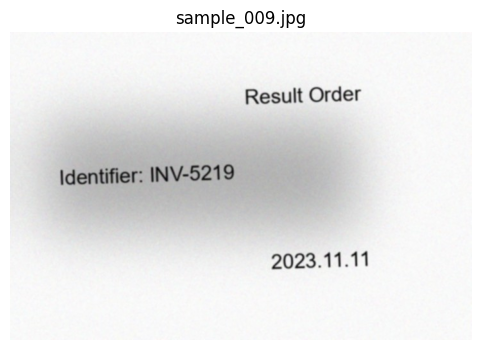

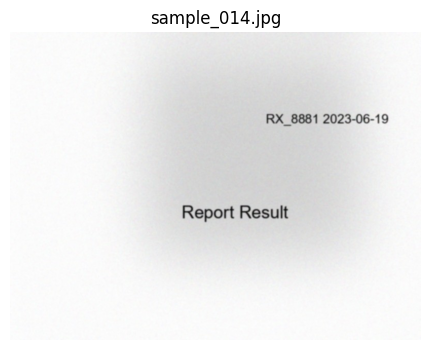

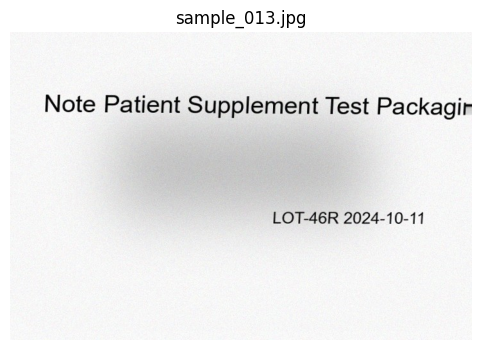

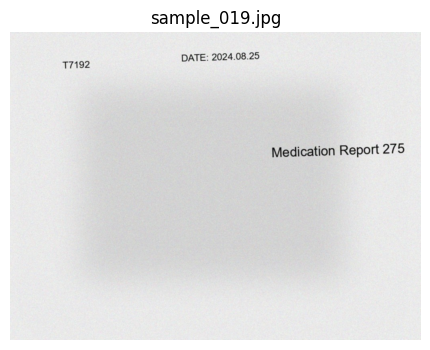

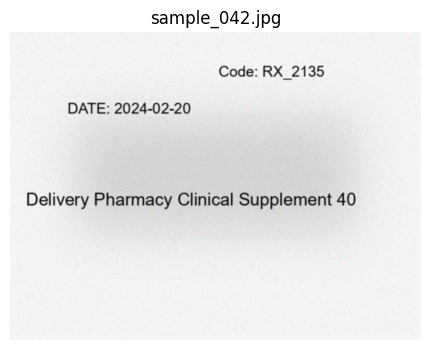

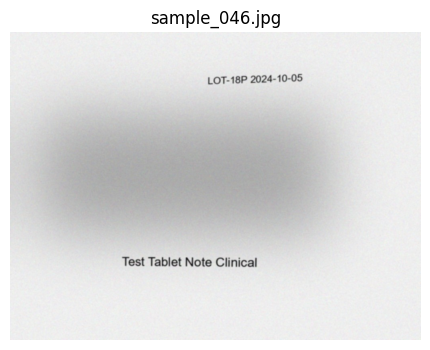

In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

SAMPLES_DIR = "./samples"
files = [f for f in os.listdir(SAMPLES_DIR) if f.lower().endswith(".jpg")]
for fn in random.sample(files, k=min(6, len(files))):
    img = Image.open(os.path.join(SAMPLES_DIR, fn))
    plt.figure(figsize=(6,4))
    plt.title(fn)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
